In [4]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
import time

In [2]:
# NBA season we will be analyzing

data = []

year = 2021
for month in ['december', 'january', 'february', 'march', 'april']: # ignore may/june because of play-in / play-offs
  # URL page we will scraping (see image above)
  url = "https://www.basketball-reference.com/leagues/NBA_{}_games-{}.html".format(year, month)
  #url = "https://www.basketball-reference.com/leagues/NBA_{}_per_game.html".format(year)

  # this is the HTML from the given URL
  html = urlopen(url)

  soup = BeautifulSoup(html, "lxml")

  # use findALL() to get the column headers
  soup.findAll('tr', limit=2)

  # use getText()to extract the text we need into a list
  headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]

  # exclude the first column as we will not need the ranking order from Basketball Reference for the analysis
  headers = headers[1:]
  print(headers)

  # avoid the first header row
  rows = soup.findAll('tr')[1:]
  for i in range(len(rows)):
    box_score_link = None
    date = None
    for td in rows[i].findAll('a'):
      if td.getText() == 'Box Score':
        box_score_link = td.get('href')
        print(box_score_link)
        date = box_score_link[-17:-9]
        print(date)
        data.append((date, box_score_link))

['Start (ET)', 'Visitor/Neutral', 'PTS', 'Home/Neutral', 'PTS', '\xa0', '\xa0', 'Attend.', 'Arena', 'Notes']
/boxscores/202012220BRK.html
20201222
/boxscores/202012220LAL.html
20201222
/boxscores/202012230CLE.html
20201223
/boxscores/202012230IND.html
20201223
/boxscores/202012230ORL.html
20201223
/boxscores/202012230PHI.html
20201223
/boxscores/202012230TOR.html
20201223
/boxscores/202012230BOS.html
20201223
/boxscores/202012230CHI.html
20201223
/boxscores/202012230MEM.html
20201223
/boxscores/202012230MIN.html
20201223
/boxscores/202012230DEN.html
20201223
/boxscores/202012230POR.html
20201223
/boxscores/202012230PHO.html
20201223
/boxscores/202012250MIA.html
20201225
/boxscores/202012250MIL.html
20201225
/boxscores/202012250BOS.html
20201225
/boxscores/202012250LAL.html
20201225
/boxscores/202012250DEN.html
20201225
/boxscores/202012260MEM.html
20201226
/boxscores/202012260CHO.html
20201226
/boxscores/202012260DET.html
20201226
/boxscores/202012260WAS.html
20201226
/boxscores/202012

In [7]:
def not_box_score(s):
    return s[:8] != 'all_box-' or s[11:] != '-game-basic'

import requests

all_data = []
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}

session = requests.Session()
session.headers.update(headers)

for d, url_d in data:
    print(url_d)
    success = False
    while not success:
        try:
            response = session.get("https://www.basketball-reference.com{}".format(url_d))
            response.raise_for_status()  # This will raise an error for 4xx and 5xx responses
            success = True  # If the request was successful, set success to True to exit the loop
        except requests.exceptions.HTTPError as e:
            if e.response.status_code == 429:
                wait_time = int(e.response.headers.get('Retry-After', 60))  # Default to 60 seconds if not provided
                wait_time = min(wait_time, 30)  # Limit the wait time to 60 seconds
                print(f"Rate limit exceeded, waiting for {wait_time} seconds.")
                time.sleep(wait_time)
            else:
                print(f"An error occurred: {e}")
                break  # Exit the loop for any other HTTP errors

        if success:
            soup_d = BeautifulSoup(response.text, "lxml")
            date_d = datetime.strptime(d, '%Y%m%d')
            divs_d = soup_d.findAll('div')
            for div in divs_d:
                if 'id' not in div.attrs.keys() or not_box_score(div['id']) or div['class'][0] != 'table_wrapper':
                    continue
                rows_d = div.findAll('tr')
                for row in rows_d:
                    col_head = row.findAll('th')[0].attrs
                    if 'data-stat' not in col_head.keys() or col_head['data-stat'] != 'player' or 'csk' not in col_head.keys():
                        continue
                    player_name = col_head['csk']
                    cols = row.findAll('td')
                    for col in cols:
                        if col.attrs['data-stat'] == 'pts':
                            pts = int(col.getText())
                            print((player_name, pts))
                            all_data.append((date_d, player_name, pts))
        else:
            # If the request was not successful after retries, you might want to log it or handle it accordingly.
            print(f"Failed to process URL: {url_d}")
        time.sleep(1)

/boxscores/202012220BRK.html
Rate limit exceeded, waiting for 3246 seconds.


KeyboardInterrupt: 

In [33]:
df = pd.DataFrame(all_data, columns = ['Date', 'Player', 'Pts'])

In [59]:
pts_total = df.groupby(['Player'])['Pts'].sum().reset_index().sort_values('Pts', ascending=False)
pts_total.head(20)

,Player,Pts
113,"Curry,Stephen",1721
37,"Beal,Bradley",1678
257,"Jokić,Nikola",1649
291,"Lillard,Damian",1642
127,"Dončić,Luka",1600
515,"Williamson,Zion",1555
491,"Vučević,Nikola",1525
462,"Tatum,Jayson",1506
57,"Booker,Devin",1503
413,"Randle,Julius",1492


In [42]:
dfw = df.groupby([pd.Grouper(key='Date', freq='W-MON'), 'Player'])['Pts'].sum().reset_index().sort_values(['Date', 'Pts'], ascending=[True,False])

In [141]:
weeks = dfw.Date.unique()
top_scorers = []
for week in weeks:
    top_scorers_this_week = dfw[dfw.Date == week].head(10)
    print(top_scorers_this_week.reset_index(drop=True).to_markdown())
    top_scorers.append(top_scorers_this_week.values[0][1])
from collections import Counter
top_scorers_count = Counter(top_scorers)
top_scorers_count

|    | Date                | Player          |   Pts |
|---:|:--------------------|:----------------|------:|
|  0 | 2020-12-28 00:00:00 | Young,Trae      |   102 |
|  1 | 2020-12-28 00:00:00 | Beal,Bradley    |    99 |
|  2 | 2020-12-28 00:00:00 | James,LeBron    |    91 |
|  3 | 2020-12-28 00:00:00 | Irving,Kyrie    |    88 |
|  4 | 2020-12-28 00:00:00 | McCollum,CJ     |    87 |
|  5 | 2020-12-28 00:00:00 | Dončić,Luka     |    83 |
|  6 | 2020-12-28 00:00:00 | Sexton,Collin   |    81 |
|  7 | 2020-12-28 00:00:00 | Durant,Kevin    |    80 |
|  8 | 2020-12-28 00:00:00 | Ingram,Brandon  |    80 |
|  9 | 2020-12-28 00:00:00 | Middleton,Khris |    80 |
|    | Date                | Player                |   Pts |
|---:|:--------------------|:----------------------|------:|
|  0 | 2021-01-04 00:00:00 | Curry,Stephen         |   149 |
|  1 | 2021-01-04 00:00:00 | Brown,Jaylen          |   137 |
|  2 | 2021-01-04 00:00:00 | Tatum,Jayson          |   135 |
|  3 | 2021-01-04 00:00:00 | Beal,B

Counter({'Young,Trae': 1,
         'Curry,Stephen': 5,
         'Beal,Bradley': 4,
         'Lillard,Damian': 1,
         'Brown,Jaylen': 1,
         'Murray,Jamal': 1,
         'Morant,Ja': 1,
         'Westbrook,Russell': 1,
         'LaVine,Zach': 1,
         "Fox,De'Aaron": 1,
         'Booker,Devin': 1,
         'Tatum,Jayson': 1})

In [75]:
import csv
reader = csv.DictReader(open('ppg_2021.csv'))
ppg_data = []
for row in reader:
    player_name = ','.join(reversed(row['Player'].split('\\')[0].split(' ')))
    ppg = float(row['PTS'])
    ppg_data.append((player_name, ppg))
df_ppg = pd.DataFrame(ppg_data, columns=['Player', 'PPG'])

In [143]:
df_ppg['ppg_rank'] = df_ppg['PPG'].rank(ascending=False)
df_ppg[df_ppg.Player.isin(top_scorers_count.keys())]
df_ppg.head(20)

,Player,PPG,ppg_rank
0,"Curry,Stephen",32.0,1.0
1,"Beal,Bradley",31.3,2.0
2,"Lillard,Damian",28.8,3.0
3,"Embiid,Joel",28.5,4.0
4,"Antetokounmpo,Giannis",28.1,5.0
5,"Dončić,Luka",27.7,6.0
6,"LaVine,Zach",27.4,7.0
7,"Williamson,Zion",27.0,8.0
8,"Irving,Kyrie",26.9,9.0
9,"Jokić,Nikola",26.4,11.0


In [102]:
pts_total['pts_rank'] = pts_total['Pts'].rank(ascending=False)
pts_total[pts_total.Player.isin(top_scorers_count.keys())]
pts_total['weeks_led'] = pts_total.Player.map(top_scorers_count)
df_joined = df_ppg.join(pts_total.set_index('Player'), on='Player')
df_joined['cumulative_prob'] = df_joined.weeks_led.cumsum() / 18.0

In [105]:
# list of players by weeks led and total point rankings
df_joined[df_joined.weeks_led > 0]

,Player,PPG,ppg_rank,Pts,pts_rank,weeks_led,cumulative_prob
0,"Curry,Stephen",32.0,1.0,1721.0,1.0,5.0,0.277778
1,"Beal,Bradley",31.3,2.0,1678.0,2.0,4.0,0.500000
2,"Lillard,Damian",28.8,3.0,1642.0,4.0,1.0,0.555556
6,"LaVine,Zach",27.4,7.0,1458.0,13.0,1.0,0.611111
11,"Tatum,Jayson",26.4,11.0,1506.0,8.0,1.0,0.666667
12,"Booker,Devin",25.6,13.0,1503.0,9.0,1.0,0.722222
13,"Young,Trae",25.3,14.0,1397.0,17.0,1.0,0.777778
14,"Fox,De'Aaron",25.2,15.0,1461.0,12.0,1.0,0.833333
16,"Brown,Jaylen",24.7,17.0,1414.0,14.0,1.0,0.888889
23,"Westbrook,Russell",22.2,24.0,1208.0,22.0,1.0,0.944444


<AxesSubplot:xlabel='ppg_rank'>

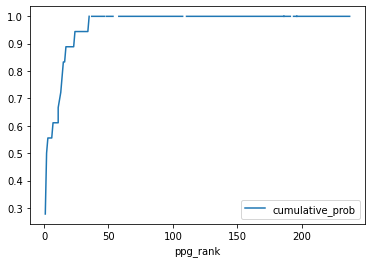

In [104]:
df_joined.plot(x='ppg_rank', y='cumulative_prob')

stdev: 44.883845
stdev: 35.171454
stdev: 22.751701
stdev: 27.478826
stdev: 31.071403
stdev: 31.584347


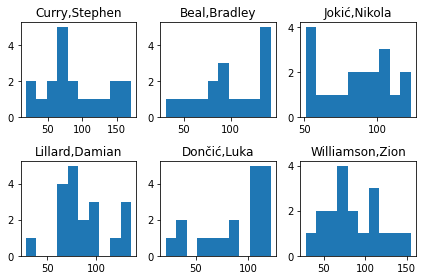

In [146]:
import matplotlib.pyplot as plt
import numpy as np
top_players = pts_total.Player.values[:6]
all_points = dfw.groupby('Date')['Pts'].sum().reset_index().set_index('Date')
plt.title('Points by Week')
for ii, player in enumerate(top_players):
    df_player = dfw[dfw.Player == player].set_index('Date').join(all_points, lsuffix='_player', rsuffix='_total')
    #plt.hist(df_player.Pts_player.values / df_player.Pts_total.values)
    #plt.title('Points Fraction by Week (%s)' % player)
    #plt.show()
    ax = plt.subplot(2, 3, ii+1)
    ax.hist(df_player.Pts_player.values)
    ax.set_title('%s' % player)
    print('stdev: %f' % np.std(df_player.Pts_player.values))
plt.tight_layout()
plt.savefig('points_variation.png', dpi=200)